### Libraries

In [1]:
import time
import shap
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
from IPython.display import Image
from sklearn.tree import export_graphviz
from yellowbrick.model_selection import FeatureImportances

from imblearn.over_sampling import SMOTE, ADASYN
from skopt.space import Real, Categorical, Integer

from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import joblib
from plot_roc import *

from sklearn.metrics  import confusion_matrix, classification_report, roc_auc_score

warnings.filterwarnings('ignore')

c:\Anaconda\envs\artigo\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from mlxtend.evaluate import cochrans_q
from mlxtend.evaluate import mcnemar_table
from mlxtend.evaluate import mcnemar

### Read 

In [3]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

X_train = pd.read_csv("X_train.csv", sep = ";")
X_test = pd.read_csv("X_test.csv", sep = ";")

y_train = pd.read_csv("y_train.csv", sep = ";")
y_test = pd.read_csv("y_test.csv", sep = ";")

X_train.head()

,RFV,H1RFV,H2RFV,CONICITY,H1LFV,PLY,LFV,RRO,CAPSPLICE,H1RRO
0,63,34,27,10.3,8.3,48.7,11.5,1.19,0.46,0.52
1,55,38,7,9.7,9.9,49.8,15.1,0.80,0.26,0.40
2,66,34,29,11.4,5.8,49.4,11.1,0.87,0.25,0.23
3,101,77,46,10.9,13.3,52.2,17.3,1.48,0.27,1.07
4,83,46,19,8.5,10.3,49.3,14.9,1.05,0.39,0.39


In [4]:
## removendo variáveis 
X_train = X_train.drop([
'H1RFV', 'H1LFV', 'H1RRO'
], axis=1)

X_test = X_test.drop([
'H1RFV', 'H1LFV', 'H1RRO'
], axis=1)

In [5]:
def prepare_targets(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    
    return y_train_enc, y_test_enc

In [6]:
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)

In [7]:
y_train.GR.value_counts()

B    35
A    34
C    11
Name: GR, dtype: int64

In [8]:
y_test.GR.value_counts()

A    12
B    11
C     4
Name: GR, dtype: int64

In [9]:
y_test_enc

array([1, 1, 0, 2, 1, 0, 1, 0, 0, 2, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 2, 0, 0, 2])

In [10]:
# y_test

In [11]:
X_test.head(5)

,RFV,H2RFV,CONICITY,PLY,LFV,RRO,CAPSPLICE
0,70,31,8.8,46.9,18.6,0.87,0.26
1,74,23,6.5,46.6,11.2,1.06,0.50
2,49,22,7.4,51.3,9.7,0.88,0.14
3,81,17,9.6,51.2,11.3,1.37,0.27
4,78,21,6.8,53.0,10.6,1.20,0.40


## Predict

In [12]:
def fit_and_print(model, X_test, y_enc):
    y_pred = model.predict(X_test)
    # print("Confusion Matrix: \n", confusion_matrix(y_test_enc, y_pred))
    sns.heatmap(confusion_matrix(y_enc, y_pred), annot=True)
    print("Classification Report: \n", classification_report(y_enc, y_pred))  


def fit_and_print_v2(model, X_test):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test_enc, y_pred)
    index =["A", "B", "C"]
    columns =["A", "B", "C"]
    cm_df = pd.DataFrame(cm,columns,index)                      
    plt.figure(figsize=(8,6))  
    sns.heatmap(cm_df, annot=True)
    print("Classification Report: \n", classification_report(y_test_enc, y_pred))  

    lb = LabelBinarizer()
    lb.fit(y_test_enc)
    y_test = lb.transform(y_test_enc)
    y_pred = lb.transform(y_pred)


    roc_auc = roc_auc_score(y_test, y_pred, multi_class = 'ovr', average=None)
    gini = 2*roc_auc -1
    print("Gini: ",gini)
    print("ROC AUC:: ",roc_auc)

In [13]:
file_minmax = "./models/minmax.pickle"
file_smote = "./models/smote.pickle"

minmax = joblib.load(file_minmax)
smote= joblib.load(file_smote)

In [14]:
X_train_minmax = minmax.transform(X_train)
X_test = minmax.transform(X_test)

In [15]:
X_resampled, y_resampled = smote.fit_resample(X_train_minmax, y_train_enc)

### Random Forest 

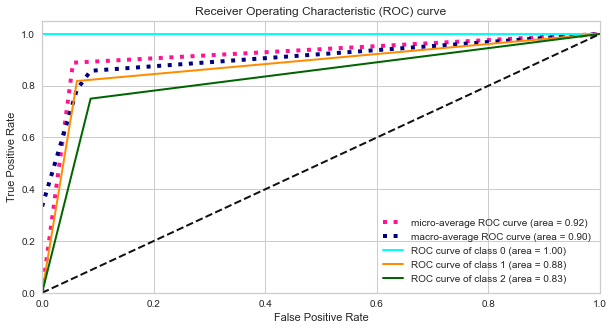

In [16]:
filename = './models/RF_best_bayes_resampled.sav'


RF_best = joblib.load(filename)
y_pred = RF_best.predict(X_test)
plot_roc_curve(y_test_enc, y_pred)

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.90      0.82      0.86        11
           2       0.60      0.75      0.67         4

    accuracy                           0.89        27
   macro avg       0.83      0.86      0.84        27
weighted avg       0.90      0.89      0.89        27

Gini:  [1.         0.75568182 0.66304348]
ROC AUC::  [1.         0.87784091 0.83152174]


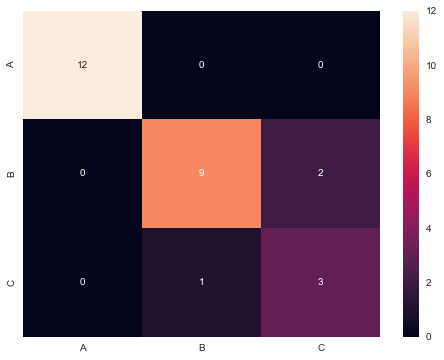

In [17]:
# fit_and_print(RF_best, X_test, y_test_enc)
fit_and_print_v2(RF_best, X_test)

In [18]:
prob_test = RF_best.predict_proba(X_test)[:,1]

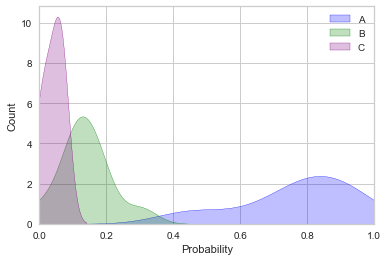

In [56]:
data=pd.DataFrame()
data['GR'] = y_test.GR
data["Probability"] = RF_best.predict_proba(X_test)[:,0]
plt.xlim(.0, 1.)
g = sns.kdeplot(data["Probability"][(data["GR"] == "A") & (data["Probability"].notnull())], color="Blue", shade = True)
g = sns.kdeplot(data["Probability"][(data["GR"] == "B") & (data["Probability"].notnull())], ax =g, color="Green", shade= True)
g = sns.kdeplot(data["Probability"][(data["GR"] == "C") & (data["Probability"].notnull())], ax =g, color="Purple", shade= True)
g.set_xlabel("Probability")
g.set_ylabel("Count")
g = g.legend(["A","B", "C"])

<AxesSubplot:xlabel='Probability', ylabel='Density'>

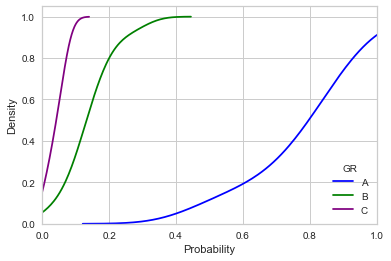

In [57]:
plt.xlim(.0, 1.)

sns.kdeplot(
    data=data, x="Probability", hue="GR",
    cumulative=True, common_norm=False, common_grid=False, hue_order=['A', 'B', 'C'], palette=["Blue", "Green", 'Purple'],
)

<AxesSubplot:xlabel='prob', ylabel='Count'>

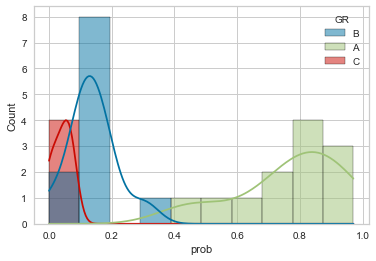

In [19]:
# sns.histplot(data["prob"][(data["GR"] == "A") & (data["prob"].notnull())], kde = True, bins=30)
sns.histplot(data, x = "prob", kde = True, hue = "GR", bins=10)

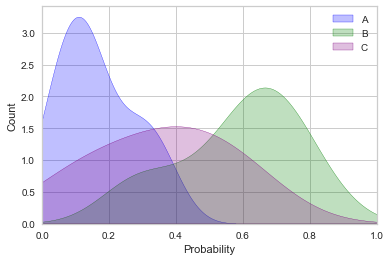

In [58]:
data=pd.DataFrame()
data['GR'] = y_test.GR
data["Probability"] = RF_best.predict_proba(X_test)[:,1]
plt.xlim(.0, 1.)
g = sns.kdeplot(data["Probability"][(data["GR"] == "A") & (data["Probability"].notnull())], color="Blue", shade = True)
g = sns.kdeplot(data["Probability"][(data["GR"] == "B") & (data["Probability"].notnull())], ax =g, color="Green", shade= True)
g = sns.kdeplot(data["Probability"][(data["GR"] == "C") & (data["Probability"].notnull())], ax =g, color="Purple", shade= True)
g.set_xlabel("Probability")
g.set_ylabel("Count")
g = g.legend(["A","B", "C"])

<AxesSubplot:xlabel='Probability', ylabel='Density'>

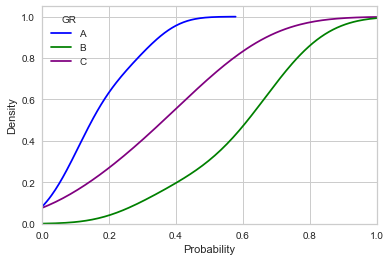

In [59]:
plt.xlim(.0, 1.)

sns.kdeplot(
    data=data, x="Probability", hue="GR",
    cumulative=True, common_norm=False, common_grid=False, hue_order=['A', 'B', 'C'], palette=["Blue", "Green", 'Purple'],
)

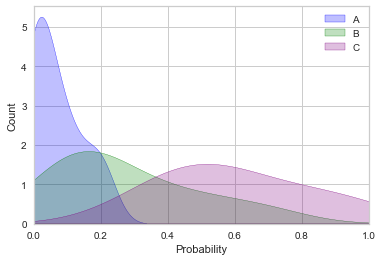

In [60]:
data=pd.DataFrame()
data['GR'] = y_test.GR
data["Probability"] = RF_best.predict_proba(X_test)[:,2]
plt.xlim(.0, 1.)
g = sns.kdeplot(data["Probability"][(data["GR"] == "A") & (data["Probability"].notnull())], color="Blue", shade = True)
g = sns.kdeplot(data["Probability"][(data["GR"] == "B") & (data["Probability"].notnull())], ax =g, color="Green", shade= True)
g = sns.kdeplot(data["Probability"][(data["GR"] == "C") & (data["Probability"].notnull())], ax =g, color="Purple", shade= True)
g.set_xlabel("Probability")
g.set_ylabel("Count")
g = g.legend(["A","B", "C"])

<AxesSubplot:xlabel='Probability', ylabel='Density'>

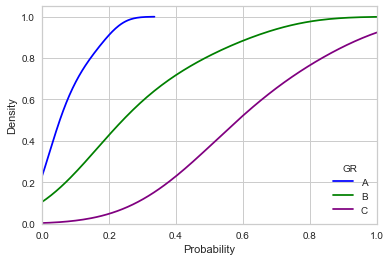

In [61]:
plt.xlim(.0, 1.)

sns.kdeplot(
    data=data, x="Probability", hue="GR",
    cumulative=True, common_norm=False, common_grid=False, hue_order=['A', 'B', 'C'], palette=["Blue", "Green", 'Purple'],
)

In [28]:
RF_best.estimators_[0]

DecisionTreeClassifier(criterion='entropy', max_depth=7, max_features='sqrt',
                       min_samples_leaf=2, min_samples_split=8,
                       random_state=74293843)

In [29]:
tree_small_0 = RF_best.estimators_[0]
tree_small_1 = RF_best.estimators_[1]
feature_list = list(X_train.columns)
name_list = ['A', 'B', 'C']

In [30]:
export_graphviz(tree_small_0, out_file = 'tree_0_smote.dot', feature_names = feature_list, class_names = name_list,  rounded = True, precision = 1, filled = True)
export_graphviz(tree_small_1, out_file = 'tree_1_smote.dot', feature_names = feature_list, class_names = name_list,  rounded = True, precision = 1, filled = True)

# !dot -Tpng tree.dot -o small_tree.png -Gdpi=600

In [31]:
# Image(filename = 'images/small_tree_0_smote.png')

In [32]:
# Image(filename = 'images/small_tree_1_smote.png')

Text(0.5, 1.0, 'Random Forest feature importance')

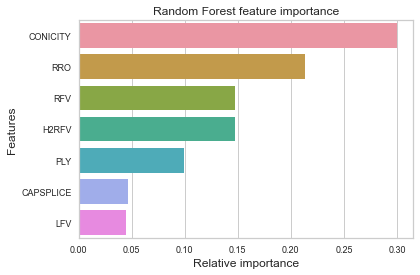

In [16]:
names_classifiers = [("Random Forest",RF_best)]
classifier = names_classifiers[0][1]
name = names_classifiers[0][0]
indices = np.argsort(classifier.feature_importances_)[::-1][:40]
g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h')
g.set_xlabel("Relative importance",fontsize=12)
g.set_ylabel("Features",fontsize=12)
g.tick_params(labelsize=9)
g.set_title(name + " feature importance")

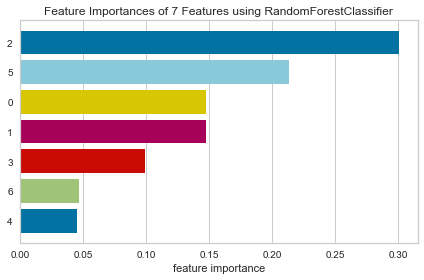

<AxesSubplot:title={'center':'Feature Importances of 7 Features using RandomForestClassifier'}, xlabel='feature importance'>

In [17]:
viz = FeatureImportances(RF_best, relative=False)
viz.fit(X_resampled, y_resampled)
viz.show()

In [16]:
explainer = shap.TreeExplainer(RF_best)
shap_values = explainer.shap_values(X_train_minmax)

In [17]:
# indices = np.argsort(shap_values)[::-1]
# X_train.columns[indices]

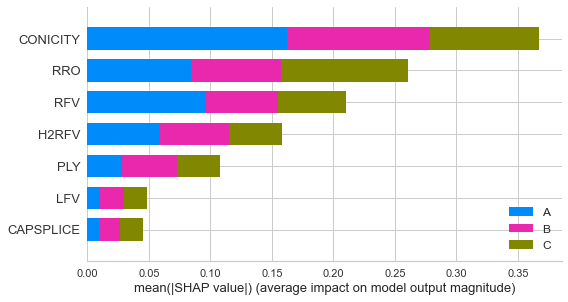

In [50]:
shap.summary_plot(shap_values, X_train_minmax, class_names= ['A', 'B', 'C'], feature_names = X_train.columns.tolist())

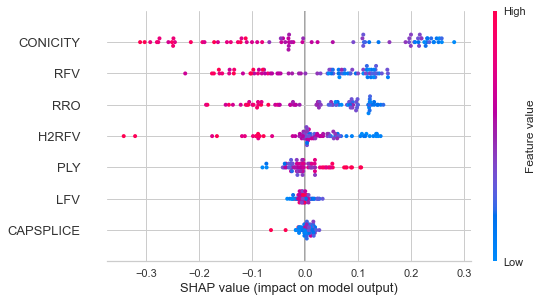

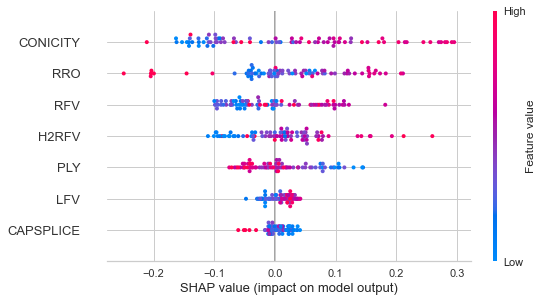

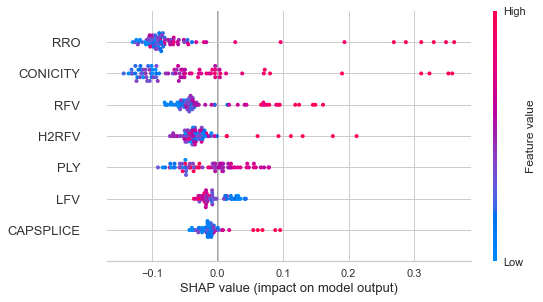

In [19]:
shap.summary_plot(shap_values[0], X_train_minmax, feature_names = X_train.columns.tolist())
shap.summary_plot(shap_values[1], X_train_minmax, feature_names = X_train.columns.tolist())
shap.summary_plot(shap_values[2], X_train_minmax, feature_names = X_train.columns.tolist())

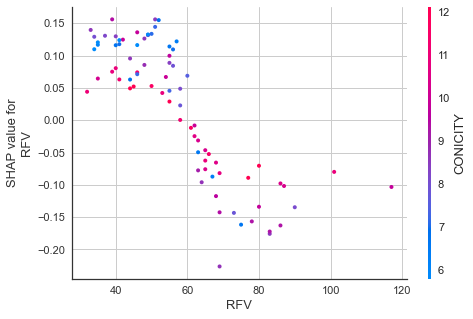

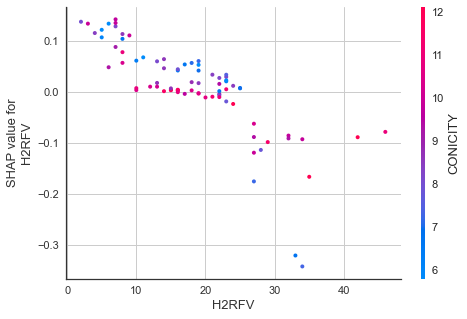

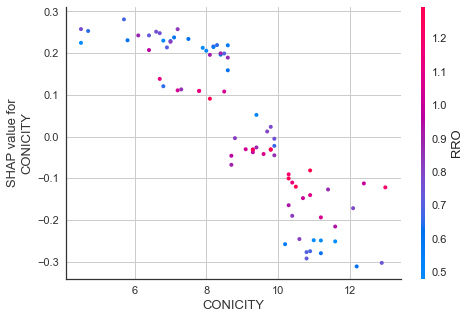

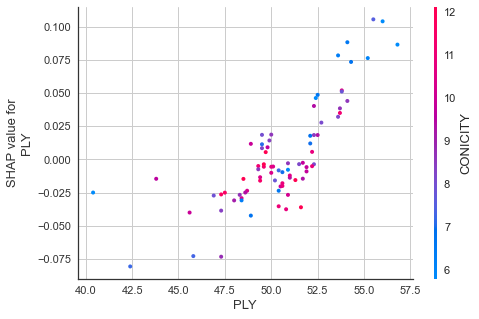

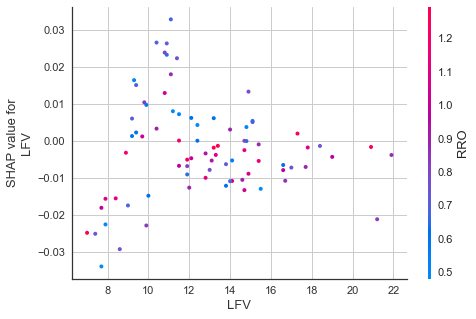

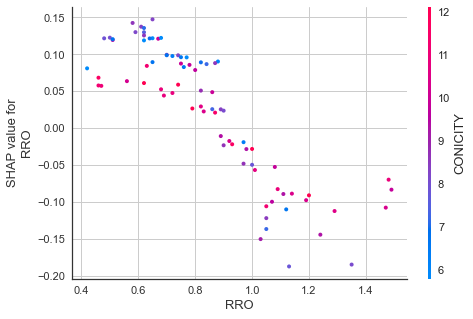

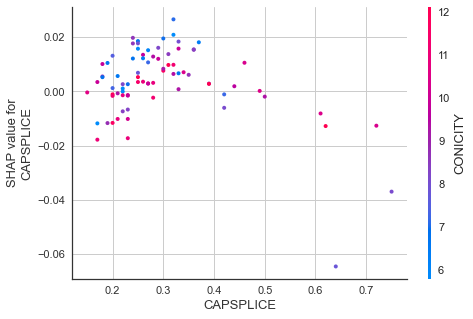

In [33]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values[0], X_train, display_features=X_train)

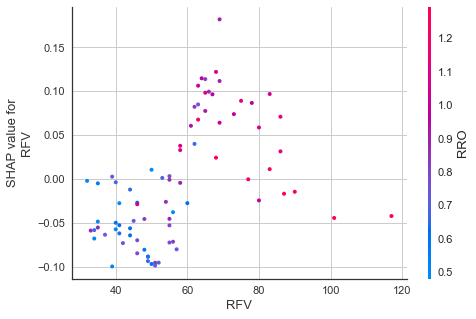

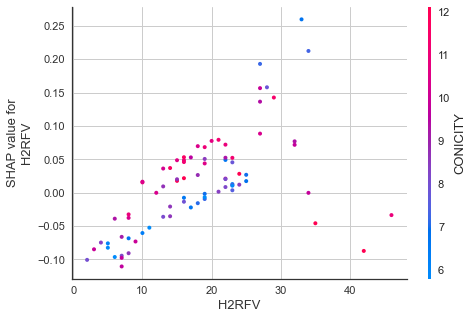

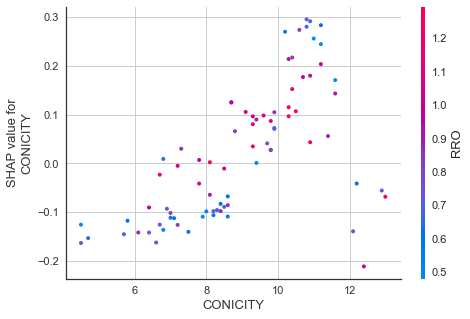

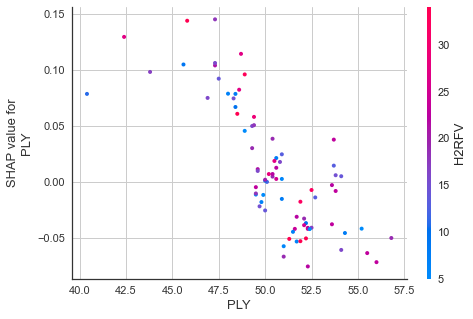

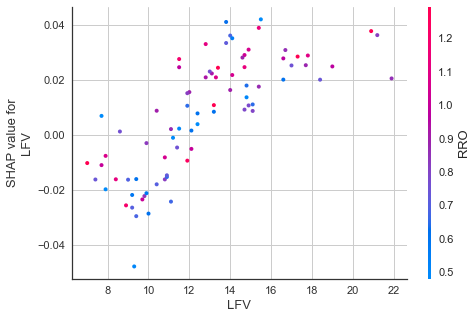

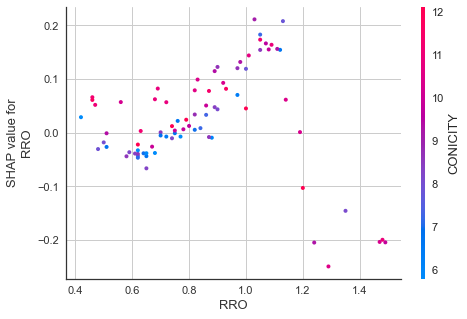

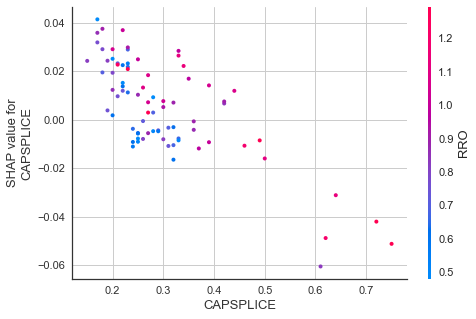

In [23]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values[1], X_train, display_features=X_train)

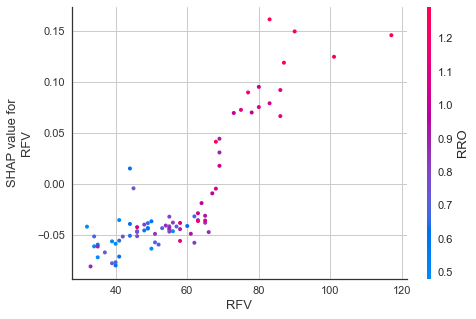

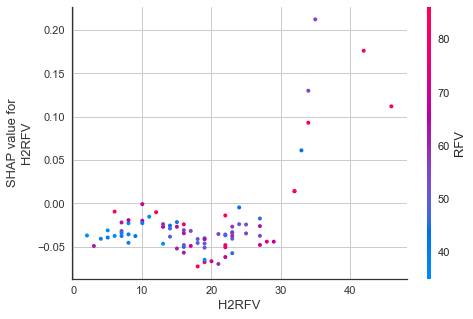

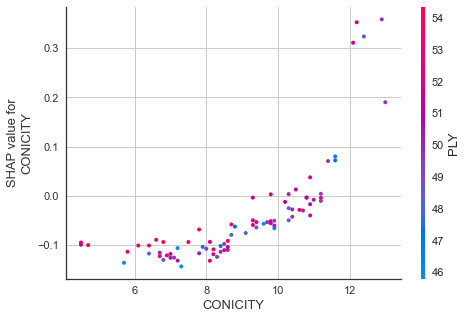

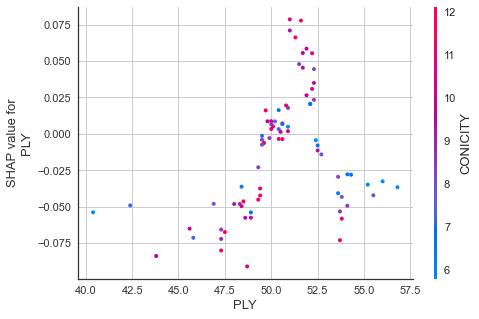

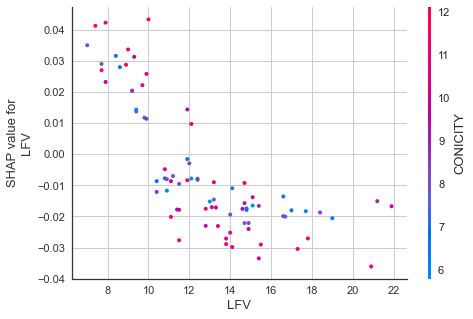

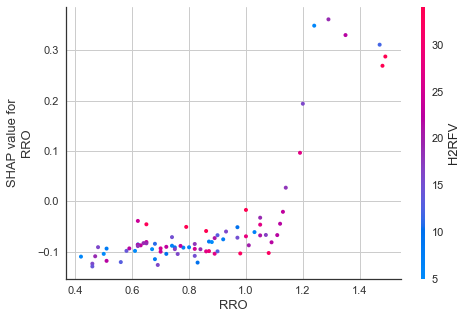

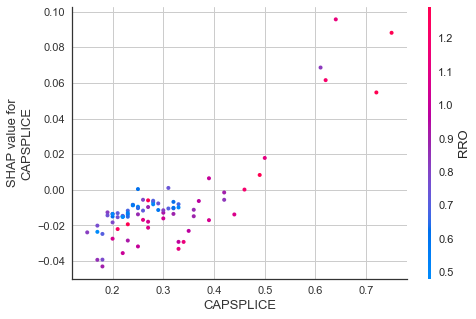

In [52]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values[2], X_train, display_features=X_train)

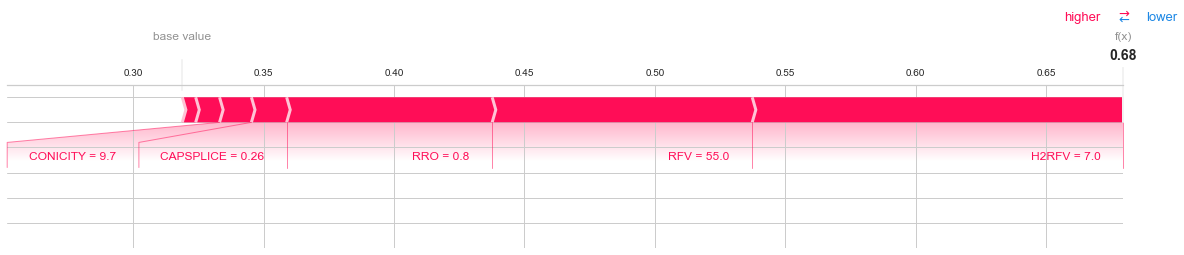

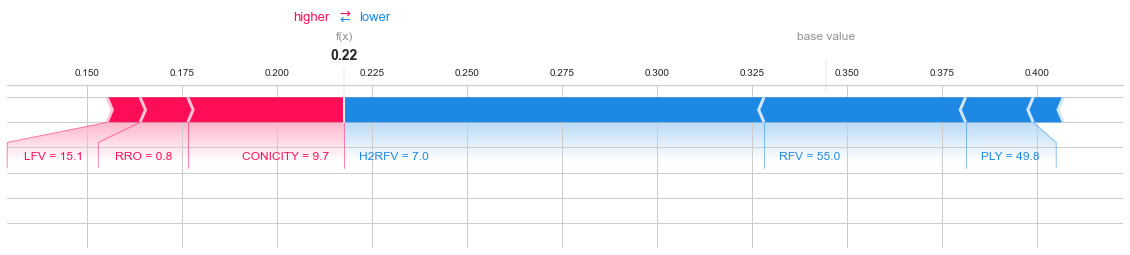

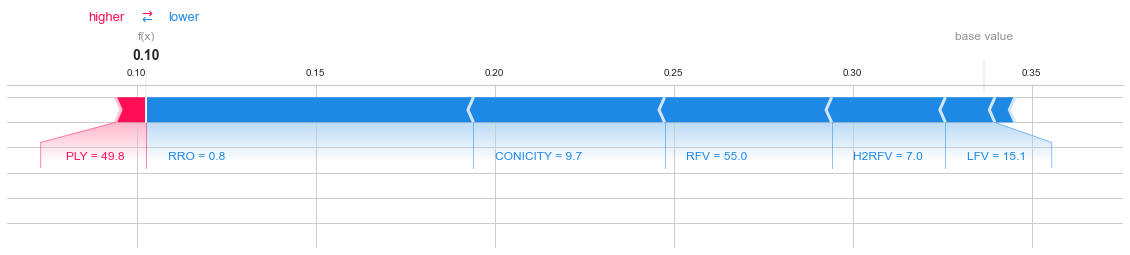

In [29]:
shap.force_plot(explainer.expected_value[0], shap_values[0][1,:], X_train.iloc[1,:], matplotlib=True)
shap.force_plot(explainer.expected_value[1], shap_values[1][1,:], X_train.iloc[1,:], matplotlib=True)
shap.force_plot(explainer.expected_value[2], shap_values[2][1,:], X_train.iloc[1,:], matplotlib=True)

In [26]:
X_train.head(1)

,RFV,H2RFV,CONICITY,PLY,LFV,RRO,CAPSPLICE
0,63,27,10.3,48.7,11.5,1.19,0.46


In [27]:
y_train

,GR
0,B
1,A
2,B
3,C
4,B
...,...
75,B
76,C
77,A
78,B


In [32]:
# shap.initjs()
# shap.force_plot(explainer.expected_value[1], shap_values[1][:,:], X_resampled.iloc[:,:])

### Support Vector Machine

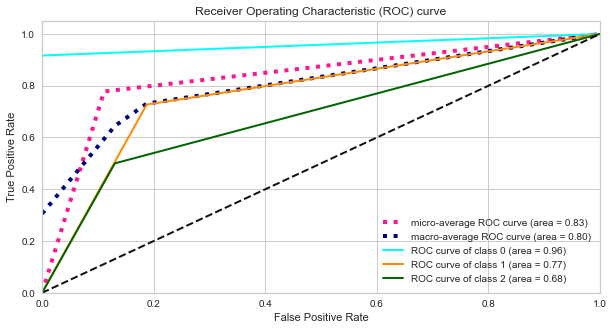

In [19]:
filename = './models/SVM_best_bayes_resampled.sav'

SVM_best = joblib.load(filename)
y_pred_svm = SVM_best.predict(X_test)
plot_roc_curve(y_test_enc, y_pred_svm)

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.73      0.73      0.73        11
           2       0.40      0.50      0.44         4

    accuracy                           0.78        27
   macro avg       0.71      0.71      0.71        27
weighted avg       0.80      0.78      0.79        27



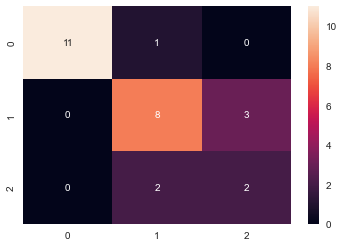

In [20]:
fit_and_print(SVM_best, X_test, y_test_enc)

In [22]:
q, p_value = cochrans_q(y_test_enc, 
                       y_pred, 
                       y_pred_svm)

print('Q: %.3f' % q)
print('p-value: %.3f' % p_value)

Q: 1.800
p-value: 0.180


In [23]:
from mlxtend.evaluate import combined_ftest_5x2cv

f, p = combined_ftest_5x2cv(estimator1=RF_best,
                            estimator2=SVM_best,
                            X=X_resampled, y=y_resampled,
                            random_seed=185585)

print('F statistic: %.3f' % f)
print('p value: %.3f' % p)

F statistic: 0.745
p value: 0.677


### Logistic Regression 

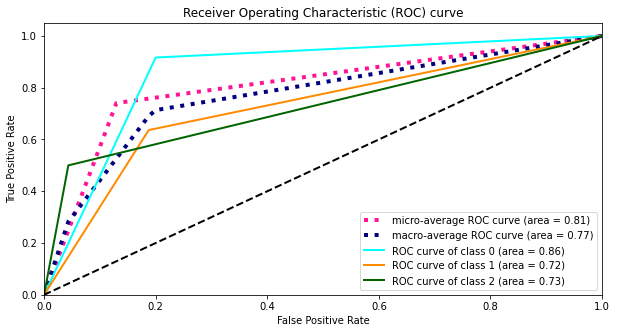

In [19]:
filename = './models/LR_best_bayes_resampled.sav'

LR_best = joblib.load(filename)
y_pred = LR_best.predict(X_test)
plot_roc_curve(y_test_enc, y_pred)

Classification Report: 
               precision    recall  f1-score   support

           0       0.79      0.92      0.85        12
           1       0.70      0.64      0.67        11
           2       0.67      0.50      0.57         4

    accuracy                           0.74        27
   macro avg       0.72      0.68      0.69        27
weighted avg       0.73      0.74      0.73        27



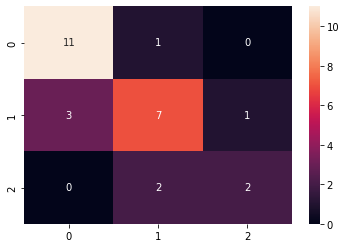

In [20]:
fit_and_print(LR_best, X_test, y_test_enc)

Classification Report: 
               precision    recall  f1-score   support

           0       0.87      0.97      0.92        34
           1       0.92      0.69      0.79        35
           2       0.62      0.91      0.74        11

    accuracy                           0.84        80
   macro avg       0.81      0.86      0.81        80
weighted avg       0.86      0.84      0.84        80



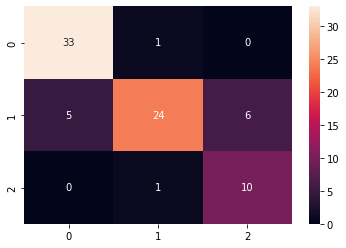

In [21]:
fit_and_print(LR_best, X_train, y_train_enc)

### Multi-layer Perceptron

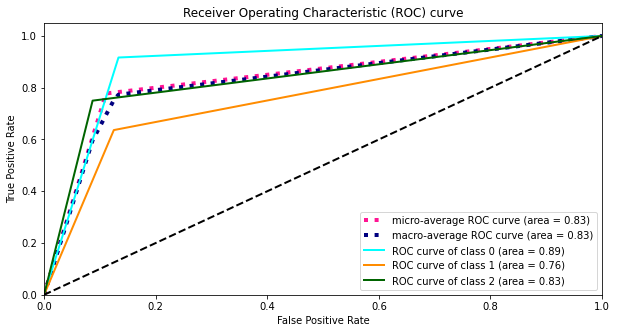

In [22]:
filename = './models/MLP_best_resampled.sav'

MLP_best = joblib.load(filename)
y_pred = MLP_best.predict(X_test)
plot_roc_curve(y_test_enc, y_pred)

Classification Report: 
               precision    recall  f1-score   support

           0       0.85      0.92      0.88        12
           1       0.78      0.64      0.70        11
           2       0.60      0.75      0.67         4

    accuracy                           0.78        27
   macro avg       0.74      0.77      0.75        27
weighted avg       0.78      0.78      0.78        27



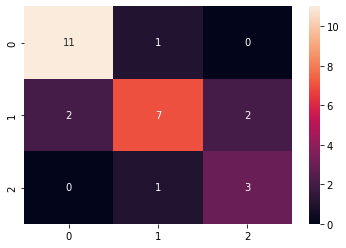

In [23]:
fit_and_print(MLP_best, X_test, y_test_enc)

Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.97      0.94        34
           1       0.93      0.80      0.86        35
           2       0.71      0.91      0.80        11

    accuracy                           0.89        80
   macro avg       0.85      0.89      0.87        80
weighted avg       0.90      0.89      0.89        80



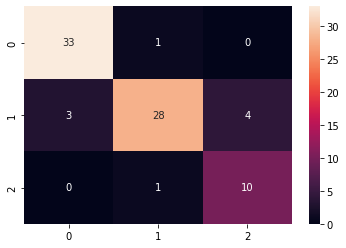

In [24]:
fit_and_print(MLP_best, X_train, y_train_enc)

### KNN

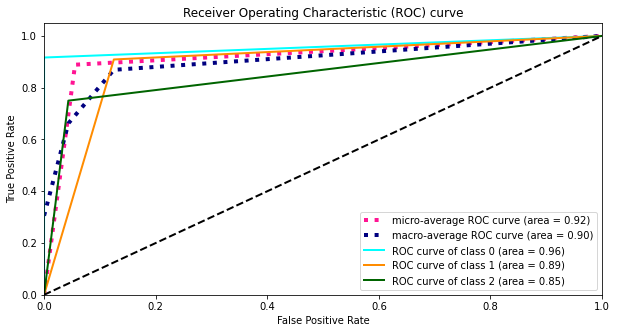

In [25]:
filename = './models/KNN_best_bayes_resampled.sav'

KNN_best = joblib.load(filename)
y_pred = KNN_best.predict(X_test)
plot_roc_curve(y_test_enc, y_pred)

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.83      0.91      0.87        11
           2       0.75      0.75      0.75         4

    accuracy                           0.89        27
   macro avg       0.86      0.86      0.86        27
weighted avg       0.90      0.89      0.89        27



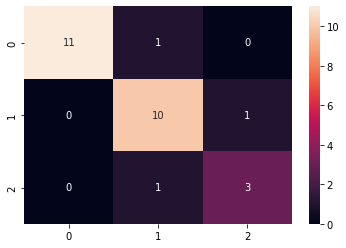

In [27]:
fit_and_print(KNN_best, X_test, y_test_enc)

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        35
           2       1.00      1.00      1.00        11

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80



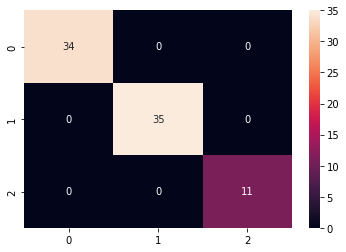

In [28]:
fit_and_print(KNN_best, X_train, y_train_enc)

### Gaussian Process

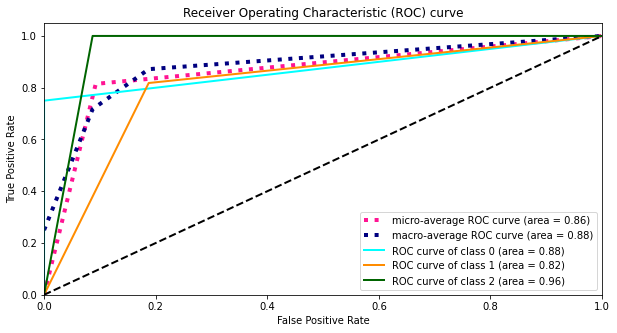

In [29]:
filename = './models/GP_best_bayes_resampled.sav'

GP_best = joblib.load(filename)
y_pred = GP_best.predict(X_test)
plot_roc_curve(y_test_enc, y_pred)

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.75      0.86        12
           1       0.75      0.82      0.78        11
           2       0.67      1.00      0.80         4

    accuracy                           0.81        27
   macro avg       0.81      0.86      0.81        27
weighted avg       0.85      0.81      0.82        27



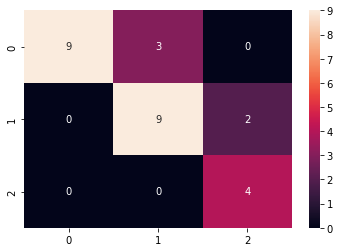

In [30]:
fit_and_print(GP_best, X_test, y_test_enc)

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        35
           2       1.00      1.00      1.00        11

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80



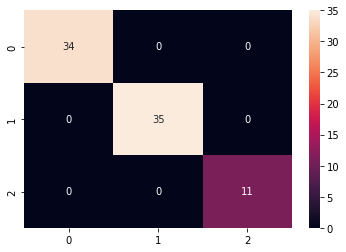

In [31]:
fit_and_print(GP_best, X_train, y_train_enc)

### GBM

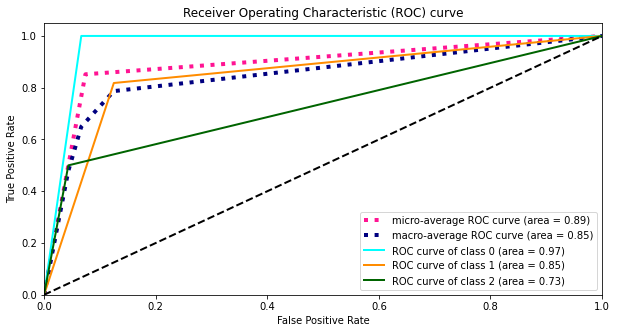

In [32]:
filename = './models/GBM_best_bayes_resampled.sav'

GBM_best = joblib.load(filename)
y_pred = GBM_best.predict(X_test)
plot_roc_curve(y_test_enc, y_pred)

Classification Report: 
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       0.82      0.82      0.82        11
           2       0.67      0.50      0.57         4

    accuracy                           0.85        27
   macro avg       0.80      0.77      0.78        27
weighted avg       0.84      0.85      0.84        27



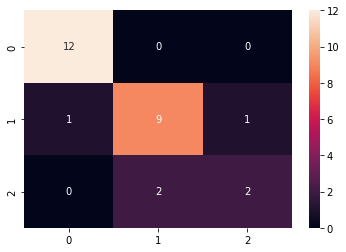

In [33]:
fit_and_print(GBM_best, X_test, y_test_enc)

### LGBM

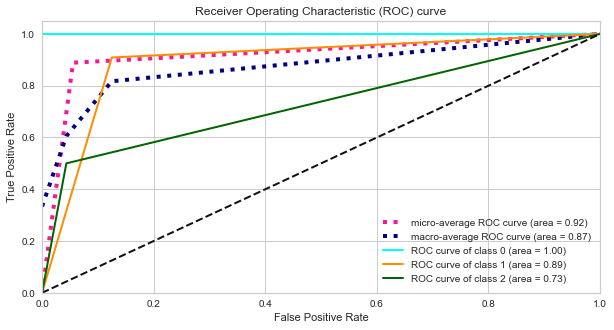

In [16]:
filename = './models/LGBM_best_bayes_resampled.sav'

LGBM_best = joblib.load(filename)
y_pred = LGBM_best.predict(X_test)
plot_roc_curve(y_test_enc, y_pred)


Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.83      0.91      0.87        11
           2       0.67      0.50      0.57         4

    accuracy                           0.89        27
   macro avg       0.83      0.80      0.81        27
weighted avg       0.88      0.89      0.88        27



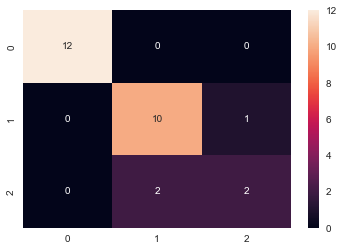

In [17]:
fit_and_print(LGBM_best, X_test, y_test_enc)

In [18]:
explainer = shap.TreeExplainer(LGBM_best)
shap_values = explainer.shap_values(X_resampled) 

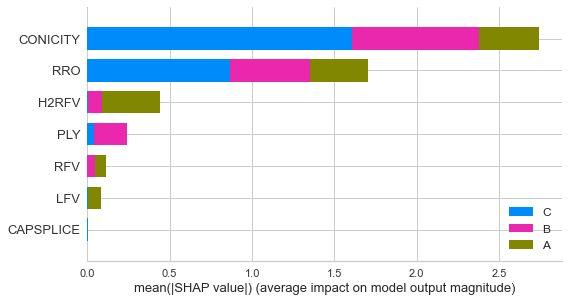

In [19]:
shap.summary_plot(shap_values, X_resampled, class_names= ['A', 'B', 'C'])

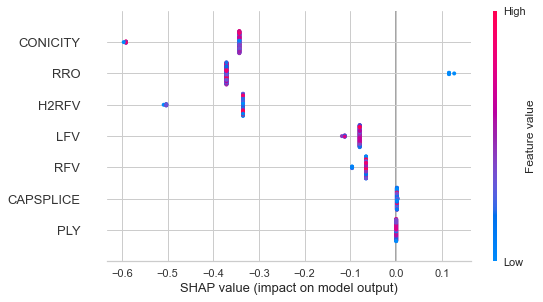

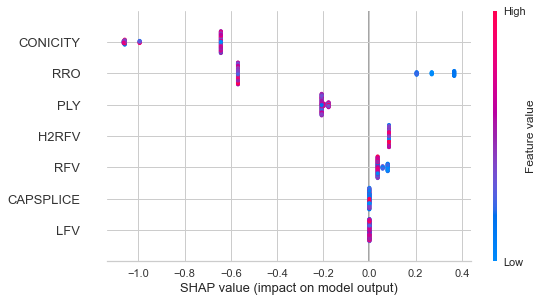

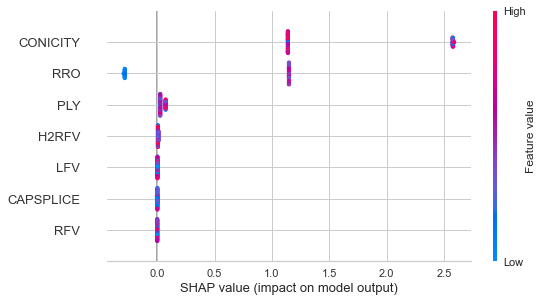

In [20]:
shap.summary_plot(shap_values[0], X_resampled)
shap.summary_plot(shap_values[1], X_resampled)
shap.summary_plot(shap_values[2], X_resampled)

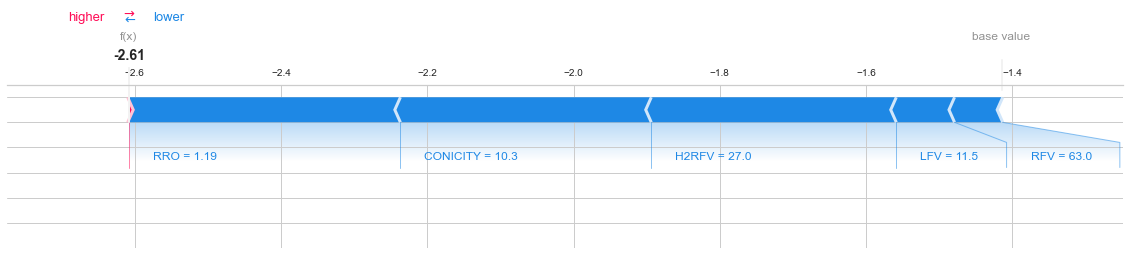

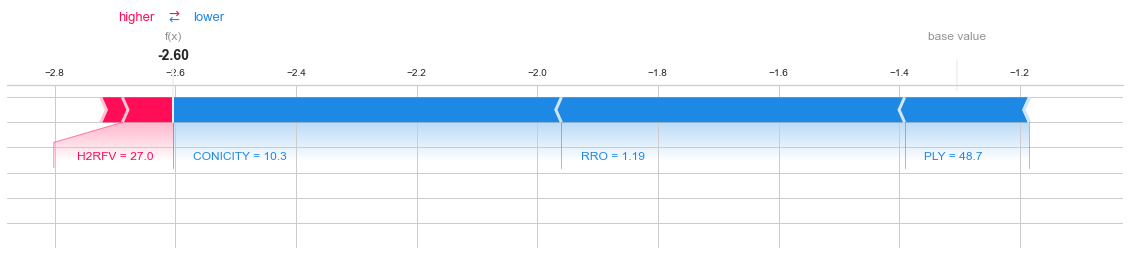

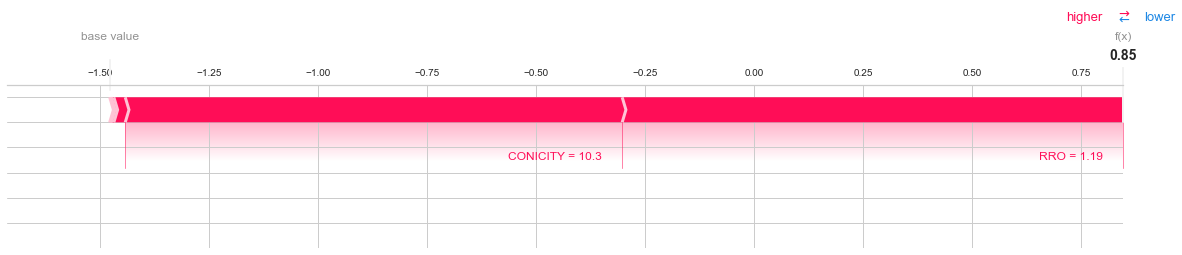

In [21]:
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_resampled.iloc[0,:], matplotlib=True)
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_resampled.iloc[0,:], matplotlib=True)
shap.force_plot(explainer.expected_value[2], shap_values[2][0,:], X_resampled.iloc[0,:], matplotlib=True)

In [49]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][:,:], X_resampled.iloc[:,:])

In [50]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][:,:], X_resampled.iloc[:,:])

In [51]:
shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][:,:], X_resampled.iloc[:,:])

### XGBoost

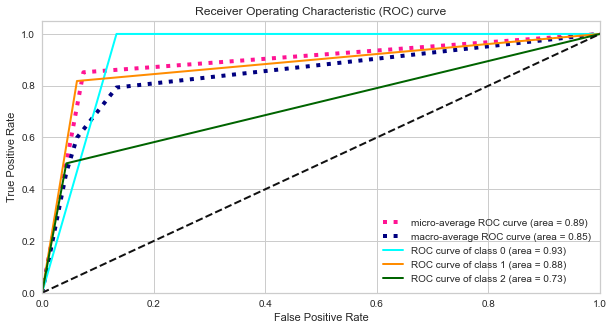

In [52]:
filename = './models/XGB_best_bayes_resampled.sav'

XGB_best = joblib.load(filename)
y_pred = XGB_best.predict(X_test)
plot_roc_curve(y_test_enc, y_pred)

Classification Report: 
               precision    recall  f1-score   support

           0       0.86      1.00      0.92        12
           1       0.90      0.82      0.86        11
           2       0.67      0.50      0.57         4

    accuracy                           0.85        27
   macro avg       0.81      0.77      0.78        27
weighted avg       0.85      0.85      0.84        27



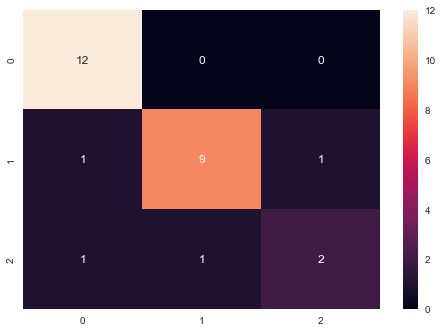

In [53]:
fit_and_print(XGB_best, X_test, y_test_enc)

In [54]:
explainer = shap.TreeExplainer(XGB_best)
shap_values = explainer.shap_values(X_resampled) 

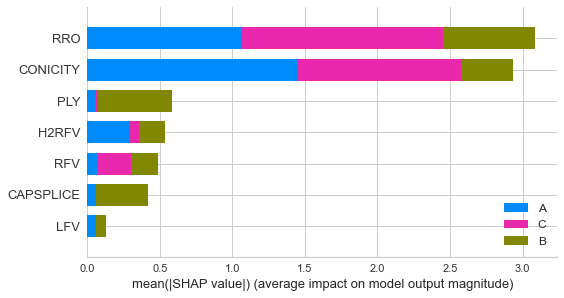

In [55]:
shap.summary_plot(shap_values, X_resampled, class_names= ['A', 'B', 'C'])

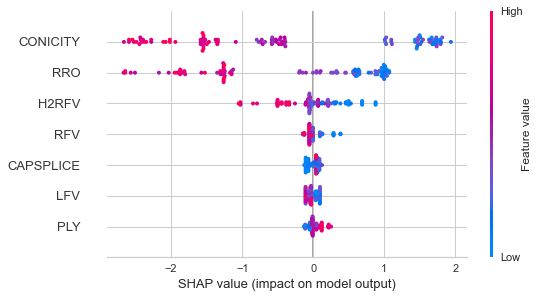

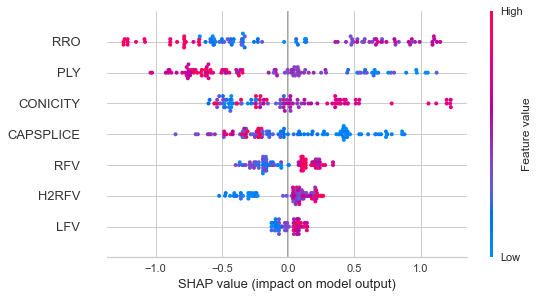

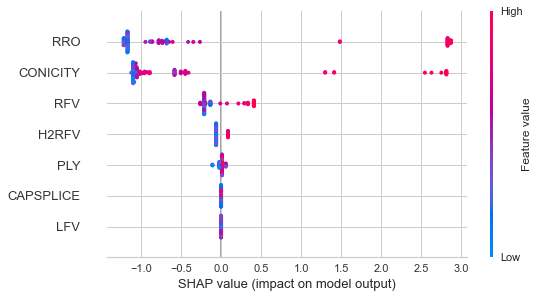

In [56]:
shap.summary_plot(shap_values[0], X_resampled)
shap.summary_plot(shap_values[1], X_resampled)
shap.summary_plot(shap_values[2], X_resampled)